# Demonstration of how to use CellSegmentationTracker


In this code, it will be demonstrated how to use CellSegmentationTracker and its methods. If you like, you can use the sample data file epi2500.tif, which you can download from https://github.com/simonguld/CellSegmentationTracker/blob/main/resources/epi2500.tif. 

In this folder, you can also find the xml file generated by running the segmentation and tracking as well as the spots, tracks and edges csv files generated by CellSegmentationTracker.

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import rcParams

from CellSegmentationTracker_dev import CellSegmentationTracker

d = {'figure.figsize': (7,6)}
rcParams.update(d)


In [2]:
spots_df = pd.read_csv('C:\\Users\\Simon Andersen\\Projects\\Projects\\CellSegmentationTracker\\resources\\epi2500_spots.csv')
tracks_df = pd.read_csv('C:\\Users\\Simon Andersen\\Projects\\Projects\\CellSegmentationTracker\\resources\\epi2500_tracks.csv')
edges_df = pd.read_csv('C:\\Users\\Simon Andersen\\Projects\\Projects\\CellSegmentationTracker\\resources\\epi2500_edges.csv')
    

In [13]:
# consider only Frame 0 of spots
#df = pd.read_csv('C:\\Users\\Simon Andersen\\Projects\\Projects\\CellSegmentationTracker\\resources\\epi2500_grid_statistics.csv')
   
df = df[df['Frame'] == 0]
df.head(10)

,Frame,T,Ngrid,x_center,y_center,cell_number,number_density,mean_velocity_X,mean_velocity_Y,interp_number_density,interp_velocity_X,interp_velocity_Y
0,0.0,0.0,0.0,305.0,795.0,0.0,NaN,NaN,NaN,0.01,-0.001355,0.003471
1,0.0,0.0,1.0,315.0,795.0,0.0,NaN,NaN,NaN,0.01,-0.001103,0.002894
2,0.0,0.0,2.0,325.0,795.0,0.0,NaN,NaN,NaN,0.01,-0.000671,0.002464
3,0.0,0.0,3.0,335.0,795.0,0.0,NaN,NaN,NaN,0.01,-0.000626,0.002617
4,0.0,0.0,4.0,345.0,795.0,0.0,NaN,NaN,NaN,0.01,-0.000626,0.002617
5,0.0,0.0,5.0,355.0,795.0,0.0,NaN,NaN,NaN,0.01,-0.000586,0.002689
6,0.0,0.0,6.0,365.0,795.0,0.0,NaN,NaN,NaN,0.01,-0.000391,0.002893
7,0.0,0.0,7.0,375.0,795.0,0.0,NaN,NaN,NaN,0.01,-0.001246,0.003158
8,0.0,0.0,8.0,385.0,795.0,1.0,0.01,-0.001246,0.003158,0.01,-0.001246,0.003158
9,0.0,0.0,9.0,395.0,795.0,0.0,NaN,NaN,NaN,0.01,-0.001456,0.003250


In [2]:
# Set whether to run segmentation tracking, whether to generate csv files or whether to simply load csv files
run_segmentation_tracking = False
generate_csv_files = False
load_csv_files = True


In the following, we will walk through the class parameters one by one and finally initialize an instance of CellSegmentationTracker:

In [3]:
#  If you want to do segmentation and tracking, you need to provide paths to the
# cellpose folder , the ImageJ program and cellpose python executable.

# Set the path to the cellpose folder. It can be found in the virtual environment created for
#running cellpose. 
# On windows, it typically found in
#  ./path_to_anaconda_folder/envs/cellpose/Lib/site-packages/cellpose
# On MAC, it is typically found in 
# ./path_to_anaconda_folder/envs/cellpose/lib/python3.[insert version here]/site-packages/cellpose
cellpose_folder_path = \
  'C:\\Users\\Simon Andersen\\miniconda3\\envs\\cellpose\\Lib\\site-packages\\cellpose'

# The ImageJ program is found in the Fiji.app folder, and has the extension .exe on Windows
#  and -macosx on MAC.
imj_path = "C:\\Users\\Simon Andersen\\Fiji.app\\ImageJ-win64.exe"

# the python executable is found in the virtual environment created for running cellpose.
cellpose_python_filepath = \
  'C:\\Users\\Simon Andersen\\miniconda3\\envs\\cellpose\\python.exe'

# Set path to .tif image file (or folder with images). If you already have an xml file, 
# you don't have to provide it
image_path = "C:\\Users\\Simon Andersen\\Projects\\Projects\\CellSegmentationTracker\\resources\\epi2500.tif"

# If you have already done segmentation and tracking, you can simply provide the path
#  to the xml file.
xml_path = None

# Set path to output folder. If None, results will be outputted in the same folder
#  as the image.
output_folder_path = None

# Set whether to use a pretrained model or not. If not, you need to provide the path
#  to a custom model
use_model = 'EPI2500'
custom_model_path = None

# Set whether to open Fiji and show the segmentation and tracking results. 
# If you choose to show the results, you must close the window before the program
#  can continue
show_segmentation = True

# Set cellpose and trackmate settings. If you don't provide any, the default settings
#  will be used
cellpose_dict = {
          'TARGET_CHANNEL' : 0,
          'OPTIONAL_CHANNEL_2': 0,
          'FLOW_THRESHOLD': 0.5, 
          'CELLPROB_THRESHOLD': -1.0,
          'CELL_DIAMETER': 0.0, # If 0.0, the diameter will be estimated by Cellpose
          'USE_GPU': False,
          'SIMPLIFY_CONTOURS': True
          }

# Beware that if you set ALLOW_TRACK_SPLITTING and/or ALLOW_TRACK_MERGING to True, 
# the calculated velocities might be incorrect, as several cells will be merged into
#  one track and can be present at the same time
trackmate_dict = {'LINKING_MAX_DISTANCE': 15.0,
                                        'GAP_CLOSING_MAX_DISTANCE': 15.0,
                                        'MAX_FRAME_GAP': 2,
                                        'ALLOW_TRACK_SPLITTING': False, 
                                        'ALLOW_TRACK_MERGING': False,
                                        'ALLOW_GAP_CLOSING': True,
            }

# Finally, you can set the names of the physical units used in the image, as well
#  as the frame interval in physical units. If you don't provide any, the default
#  values will be used (pixels and frames)
# For the epi2500 images, the frame interval is 600 seconds, but since this information
# is already stored in the .tif file, we don't need to provide it here.
# NB: The length and time scales will be automatically converted to physical units
# by TrackMate, if the physical units are set correctly in the .tif file.
unit_conversion_dict= {
                                                  'frame_interval_in_physical_units': 600,
                                                  'physical_length_unit_name': r'$\mu$m',
                                                    'physical_time_unit_name': 's',
        }


# Now having set all parameters, we are ready to initialise the CellSegmentationTracker
#  object:
cst = CellSegmentationTracker(cellpose_folder_path, imagej_filepath = imj_path, \
    cellpose_python_filepath = cellpose_python_filepath, image_folder_path = image_path, \
      xml_path = xml_path, output_folder_path = output_folder_path,\
      use_model = use_model, custom_model_path = custom_model_path,\
      show_segmentation = show_segmentation, cellpose_dict = cellpose_dict, \
        trackmate_dict = trackmate_dict, unit_conversion_dict = unit_conversion_dict)



To run the segmentation and tracking, simply call the run_segmentation_tracking() method. 

In [4]:
if run_segmentation_tracking:
    # If you are using the epi2500 sample images (without GPU), 
    # it will take 5-6 minutes to run
    # If you have chosen show_segmentation = True, 
    # you must close the Fiji window after tracking before the program can continue
    cst.run_segmentation_tracking()

In [5]:
if run_segmentation_tracking or generate_csv_files:
    # After the segmentation and tracking is done, you can store the spot, track and edge
    # features in dataframes and generate csv files for further analysis. This is done
    # by calling the generate_csv_files() method,

    ## If you simply want to calculate and save everything, you can just call the method 
    # without any arguments

    # Spot features will be extracted automatically. Decide whether to calculate cell 
    #velocities, as well as track and edge features. By default, everything is extracted
    # and saved
    calculate_velocities = True
    get_tracks = True
    get_edges = True

    # If you want to save the csv files, set save_csv_files to True 
    # and provide a name for the csv files. If None, the name will be the same as the 
    # image name.
    # The file(s) will be saved in the output folder if provided, otherwise in the same folder
    #  as the image if provided, otherwise in the current working directory

    df_spots, df_tracks, df_edges = \
        cst.generate_csv_files(calculate_velocities = calculate_velocities, \
                get_tracks = get_tracks, get_edges = get_edges, save_csv_files = True, \
                name = None)

In [6]:
if load_csv_files:
    ## It is useful to note that if you have already generated the csv files, 
    # you can simply load them.
    # To do this, you must leave the image path and xml_path empty when initialising 
    # the CellSegmentationTracker object, after which you can provide the path to 
    # the csv files as follows:
    cst.spots_df = pd.read_csv('C:\\Users\\Simon Andersen\\Projects\\Projects\\CellSegmentationTracker\\resources\\epi2500_spots.csv')
    cst.tracks_df = pd.read_csv('C:\\Users\\Simon Andersen\\Projects\\Projects\\CellSegmentationTracker\\resources\\epi2500_tracks.csv')
    cst.edges_df = pd.read_csv('C:\\Users\\Simon Andersen\\Projects\\Projects\\CellSegmentationTracker\\resources\\epi2500_edges.csv')
    

In [7]:
# To get basic settings and information about the segmentation and tracking, 
# call the print_settings() method
cst.print_settings()


Image information:  ['filename: epi2500.tif', 'folder: C:\\Users\\Simon Andersen\\Projects\\Projects\\CellSegmentationTracker\\resources\\', 'width: 2005', 'height: 1567', 'nslices: 1', 'nframes: 4', 'pixelwidth: 0.6500002275000796', 'pixelheight: 0.6500002275000796', 'voxeldepth: 1.0', 'timeinterval: 600.2135620117188', 'xstart: 0', 'xend: 2004', 'ystart: 0', 'yend: 1566', 'zstart: 0', 'zend: 0', 'tstart: 0', 'tend: 3']

Cellpose settings:  {'TARGET_CHANNEL': 0, 'OPTIONAL_CHANNEL_2': 0, 'FLOW_THRESHOLD': 0.5, 'CELLPROB_THRESHOLD': -1.0, 'CELL_DIAMETER': 0.0, 'USE_GPU': False, 'SIMPLIFY_CONTOURS': True}

Trackmate settings:  {'LINKING_MAX_DISTANCE': 15.0, 'GAP_CLOSING_MAX_DISTANCE': 15.0, 'MAX_FRAME_GAP': 2, 'ALLOW_TRACK_SPLITTING': False, 'ALLOW_TRACK_MERGING': False, 'ALLOW_GAP_CLOSING': True} 



In [8]:
# You can print all spot, track and edges feature names by calling
cst.get_feature_keys()


Spot features:  Index(['Frame', 'T', 'X', 'Y', 'Z', 'Radius', 'Visibility',
       'Manual spot color', 'Ellipse center x0', 'Ellipse center y0',
       'Ellipse short axis', 'Ellipse long axis', 'Ellipse angle',
       'Ellipse aspect ratio', 'Area', 'Perimeter', 'Circularity', 'Solidity',
       'Shape index', 'Quality', 'Mean intensity ch1', 'Median intensity ch1',
       'Min intensity ch1', 'Max intensity ch1', 'Sum intensity ch1',
       'Std intensity ch1', 'Contrast ch1', 'Signal/Noise ratio ch1',
       'Spot ID', 'TRACK_ID', 'Velocity_X', 'Velocity_Y'],
      dtype='object')
Track features:  Index(['TRACK_INDEX', 'TRACK_ID', 'NUMBER_SPOTS', 'NUMBER_GAPS',
       'NUMBER_SPLITS', 'NUMBER_MERGES', 'NUMBER_COMPLEX', 'LONGEST_GAP',
       'TRACK_DURATION', 'TRACK_START', 'TRACK_STOP', 'TRACK_DISPLACEMENT',
       'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION',
       'TRACK_MEAN_SPEED', 'TRACK_MAX_SPEED', 'TRACK_MIN_SPEED',
       'TRACK_MEDIAN_SPEED', 'TRACK_STD_SPE

In [9]:
# You can get average values of observables for spot, track and edges observables
# by calling
cst.get_summary_statistics()

    


SUMMARY STATISTICS FOR SPOTS: 
All lengths are in phyiscal units, if provided. Otherwise, they are in pixels.
All times are in physical units, if provided. Otherwise, they are in frames.

Average no. of spots per frame:  2424.5
Average value of T: 900.506  ± 6.816
Average value of X: 659.367  ± 3.656
Average value of Y: 519.339  ± 2.869
Average value of Radius: 12.524  ± 0.022
Average value of Visibility: 1.000  ± 0.000
Average value of Ellipse short axis: 10.844  ± 0.021
Average value of Ellipse long axis: 15.812  ± 0.033
Average value of Ellipse angle: 0.922  ± 0.012
Average value of Ellipse aspect ratio: 1.488  ± 0.003
Average value of Area: 507.824  ± 1.791
Average value of Perimeter: 90.331  ± 0.170
Average value of Circularity: 0.765  ± 0.001
Average value of Solidity: 0.946  ± 0.000
Average value of Quality: 1202.322  ± 4.242
Average value of Mean intensity ch1: 532.761  ± 0.319
Average value of Median intensity ch1: 535.116  ± 0.354
Average value of Min intensity ch1: 261.779 

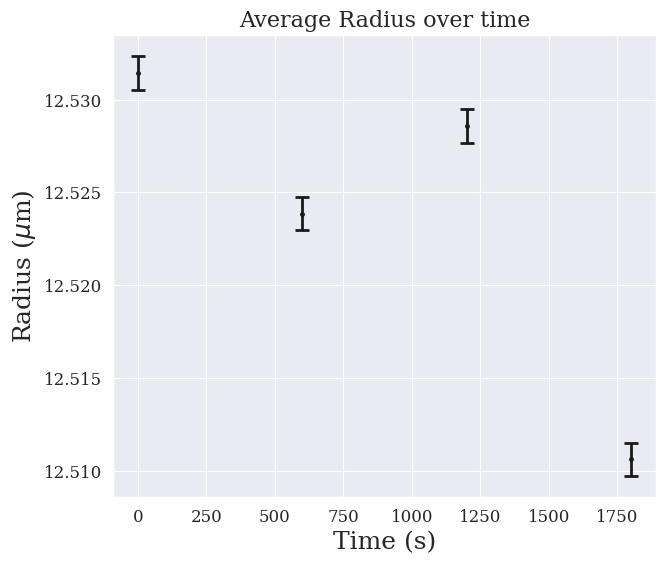

In [10]:
# To plot any spot feature over time, call the plot_feature_over_time() method. 
# Make sure to provide the name of the feature as it appears in the df_spots dataframe.

cst.plot_feature_over_time('Radius', feature_unit = r'$\mu$m')



In [11]:
# To calculate things like velocity and density fields, you need to first call the 
# calculate_grid_statistics() method. This will calculate the average value of all chosen
# spot features in a grid of cells. 
# 'Frame', 'T', 'Ngrid', 'x_center'(x-coordinate of grid center), 'y_center', 
# 'cell_number' (no. of cells per grid), 'number_density', 'mean_velocity_X', 'mean_velocity_Y' are
# automatically included, and you can choose to include any additional spot features.

# Ngrid is number of grid squares in the smallest dimension. \
#The number of grid squares in the other dimension is determined by the aspect ratio of 
#the image, with the restriction that the grid squares are square.
#If None, Ngrid is set to be the ratio between the smallest 
# spatial dimension and twice the average cell diameter, yielding roughly
#4 cells per grid square.
Ngrid = 30
# Choose any additional spot features to include in the grid statistics
include_features = ['Area',]

xmin, xmax = 300, 900
ymin, ymax = 300, 900
boundaries = [(xmin, xmax), (ymin, ymax)]

name = None
# Decide whether to save csv. It will be named after the image name if provided,
# otherwise as CellSegmentationTracker_grid_stats.csv. It will be saved in the 
# output folder, if provided, otherwise in the image folder.

grid_df = cst.calculate_grid_statistics(boundaries, Ngrid = Ngrid, include_features=include_features, \
    save_csv=True, interpolation_method='linear', name = name)

print("\nColumns in grid_df:" , list(grid_df.columns))


Average cell diameter:  25.04723941052933   $\mu$m
Dimensions of region to be gritted:  600  x  600   $\mu$m$^2$

Interpolating features...

Average no. of cells per grid:  0.8

Grid dataframe saved as csv file at:  C:\Users\Simon Andersen\Projects\Projects\CellSegmentationTracker\resources\epi2500_grid_statistics.csv

Columns in grid_df: ['Frame', 'T', 'Ngrid', 'x_center', 'y_center', 'cell_number', 'number_density', 'mean_velocity_X', 'mean_velocity_Y', 'mean_area', 'interp_number_density', 'interp_velocity_X', 'interp_velocity_Y', 'interp_area']


In [17]:
grid_df['T'].unique()

array([   0.          ,  600.2135620117, 1200.4271240234, 1800.6406860352])

In [13]:
x = ['T', 'y_center', 'mean_velocity_X']
feature_idx = [grid_df.columns.get_loc(c) for c in x if c in grid_df]
feature_idx
df = frame_df.values
df = df[:, feature_idx]
df

NameError: name 'frame_df' is not defined

In [ ]:
###TODO

# Incorop interp ind i flow field
# incorp interp for vilkårlige skalarer
# dokumenter alt, opdater docstring, readme notebook
# test test test
# opdater notebook
# build push etc, skriv val og tas amin diggedy


In [15]:
# find indices where mean_velocity_X is nan in frame_df
nan_idx = np.where(np.isnan(frame_df['mean_velocity_X']))[0]

frame_df.loc[:10]

,Frame,T,Ngrid,x_center,y_center,cell_number,number_density,mean_velocity_X,mean_velocity_Y,mean_area,interp_area,interp_number_density,interp_velocity_X,interp_velocity_Y
0,0.0,0.0,0.0,310.0,890.0,1.0,0.0025,0.001276,0.004373,596.781668,596.781668,0.0025,0.001276,0.004373
1,0.0,0.0,1.0,330.0,890.0,1.0,0.0025,0.000195,0.003101,520.731615,520.731615,0.0025,0.000195,0.003101
2,0.0,0.0,2.0,350.0,890.0,0.0,NaN,NaN,NaN,NaN,604.217673,0.0025,-0.000073,0.003169
3,0.0,0.0,3.0,370.0,890.0,0.0,NaN,NaN,NaN,NaN,687.703731,0.0025,-0.000341,0.003236
4,0.0,0.0,4.0,390.0,890.0,0.0,NaN,NaN,NaN,NaN,771.189790,0.0025,-0.000609,0.003304
5,0.0,0.0,5.0,410.0,890.0,0.0,NaN,NaN,NaN,NaN,854.675848,0.0025,-0.000877,0.003371
6,0.0,0.0,6.0,430.0,890.0,1.0,0.0025,-0.001145,0.003439,938.161907,938.161907,0.0025,-0.001145,0.003439
7,0.0,0.0,7.0,450.0,890.0,0.0,NaN,NaN,NaN,NaN,653.713583,0.0025,-0.001452,0.004480
8,0.0,0.0,8.0,470.0,890.0,1.0,0.0025,-0.001758,0.005521,369.265258,369.265258,0.0025,-0.001758,0.005521
9,0.0,0.0,9.0,490.0,890.0,1.0,0.0025,-0.001934,0.003410,278.005195,278.005195,0.0025,-0.001934,0.003410


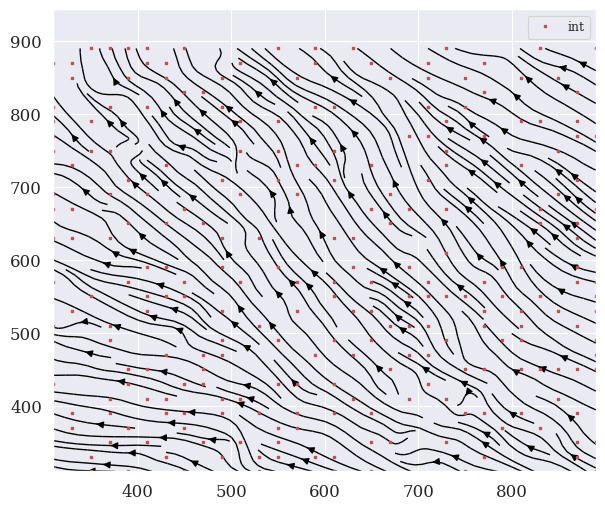

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# find data for frame 0
frame_df = grid_df[grid_df['Frame'] == 0]

Nx = len(frame_df['x_center'].unique())
Ny = len(frame_df['y_center'].unique())
X = frame_df['x_center'].values.reshape((Ny, Nx))
Y = frame_df['y_center'].values.reshape((Ny, Nx))
vx = frame_df['mean_velocity_X'].values.reshape((Ny, Nx))
vy = frame_df['mean_velocity_Y'].values.reshape((Ny, Nx))
vx_int = frame_df['interp_velocity_X'].values.reshape((Ny, Nx))
vy_int = frame_df['interp_velocity_Y'].values.reshape((Ny, Nx))

nan_mask = np.isnan(vx)
vx_nan_arr = np.zeros_like(vx)
vx_nan_arr[nan_mask] = vx_int[nan_mask]
vx_nan_arr[~nan_mask] = np.nan

x_nan_arr = np.zeros_like(X)


vy_nan_arr = np.zeros_like(vy)
vy_nan_arr[nan_mask] = vy_int[nan_mask]
vy_nan_arr[~nan_mask] = np.nan
x_nan_arr[nan_mask] = X[nan_mask]
x_nan_arr[~nan_mask] = np.nan
fig, ax = plt.subplots()
#ax.quiver(X, Y, vx, vy, units='dots', scale_units='dots')
#ax.quiver(X, Y, vx_nan_arr, vy_nan_arr, units='dots', scale_units='dots', color = 'r')
ax.streamplot(np.unique(X), np.unique(Y), np.flip(vx_int, axis = 0), np.flip(vy_int, axis = 0), density = 1.5, color = 'black', linewidth=1, arrowsize=1)
plt.plot(X[nan_mask], Y[nan_mask], 'rs', ms=1.5, label = 'int');


plt.ylim([Y.min(), Y.max() + 0.06*Y.max()])
plt.legend(loc = 'upper right', bbox_to_anchor=(1, 1), fontsize = 9)



Pixel width in TrackMate: 0.6500002275000796
Pixel height in TrackMate: 0.6500002275000796
Frame interval in physical units in TrackMate: 600.2135620117188


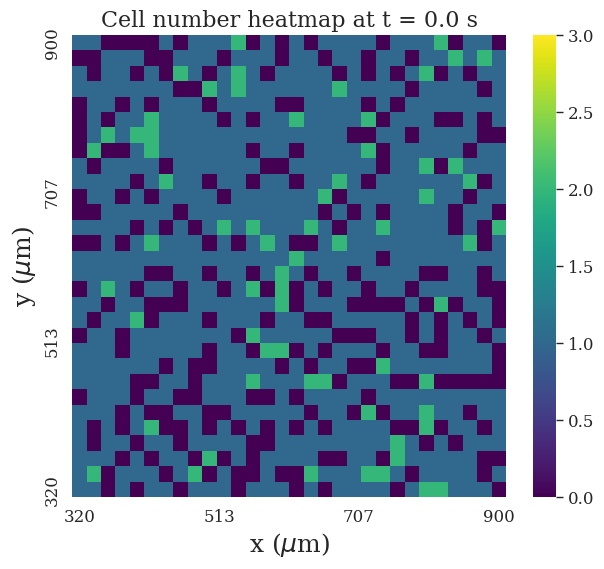

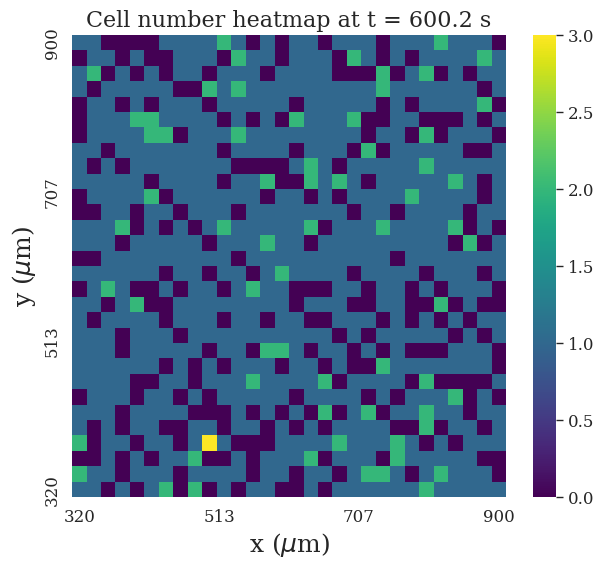

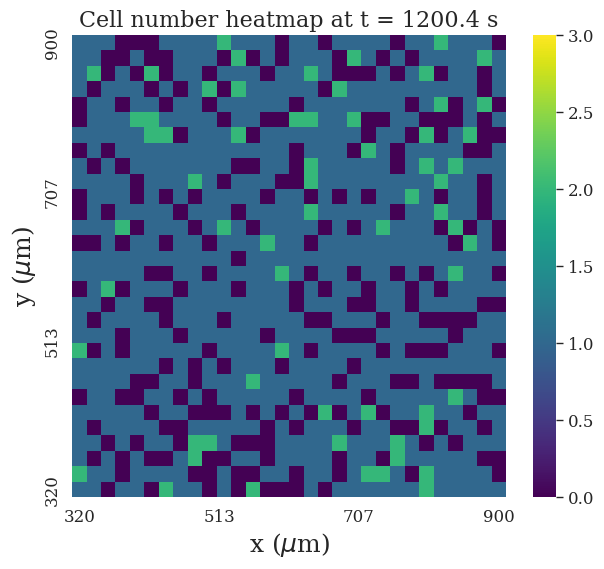

In [39]:
## Now that we have calculated the grid statistics, we can plot them.
# To plot scalar fields, call the visualize_grid_statistics() method.

# Choose which feature to plot. If None, number_density will be plotted
# NB: If you choose another feature than number_density, you must have
# included it in the grid statistics calculation
feature = 'cell_number'

# Set the unit of the feature
feature_unit = None

# Choose which frames to plot. If [0,0], all frames will be plotted
frame_range = [0,3] # left inclusive, right exclusive

# Choose whether to calculate the average over the entire frame range
calculate_average = False

# Choose whether to animate the plot (doesn't work in jupyter notebook)
animate = False
# Choose the frame interval for the animation)
frame_interval = 800
# Choose whether to show the plot
show = True

cst.visualize_grid_statistics(feature = feature, feature_unit = feature_unit,  frame_range = frame_range, \
    calculate_average = calculate_average, animate = animate, \
    frame_interval = frame_interval, show = show)


In [16]:
# Finally, to plot the velocity flow field or streamlines, 
# call the plot_velocity_field() method.

# Choose whether to plot the velocity flow field or streamlines
mode = 'field' # 'streamlines' or 'field'


# Choose which frames to plot. If [0,0], all frames will be plotted
frame_range = [0,3] # left inclusive, right exclusive

# Choose whether to calculate the average over the entire frame range
calculate_average = False

# Choose whether to animate the plot (doesn't work in jupyter notebook)
animate = True
# Choose the frame interval for the animation)
frame_interval = 800
# Choose whether to show the plot
show = True


# All the remaining arguments are the same as for visualize_grid_statistics()


cst.plot_velocity_field(mode = mode, frame_range = frame_range, \
    calculate_average = calculate_average, animate = animate, \
    frame_interval = frame_interval, use_interpolated_velocities=True, show = show)



Pixel width in TrackMate: 0.6500002275000796
Pixel height in TrackMate: 0.6500002275000796
Frame interval in physical units in TrackMate: 600.2135620117188


<Figure size 700x600 with 0 Axes>



Pixel width in TrackMate: 0.6500002275000796
Pixel height in TrackMate: 0.6500002275000796
Frame interval in physical units in TrackMate: 600.2135620117188


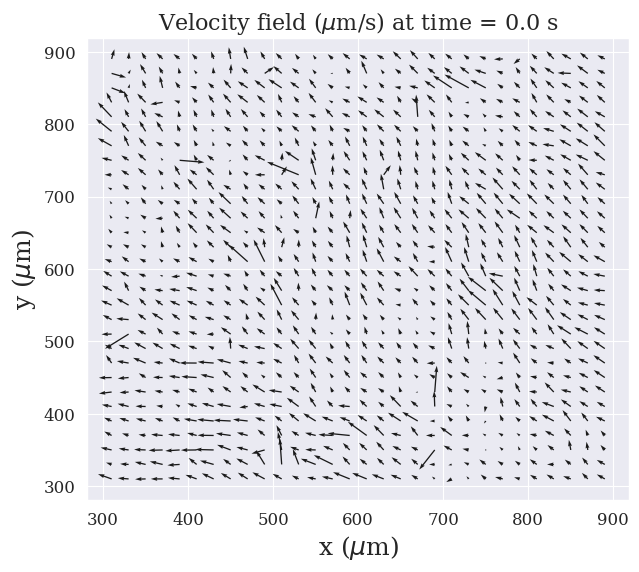

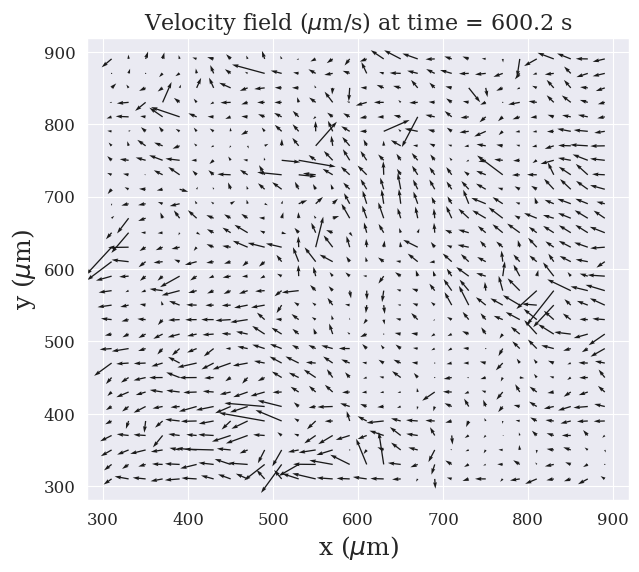

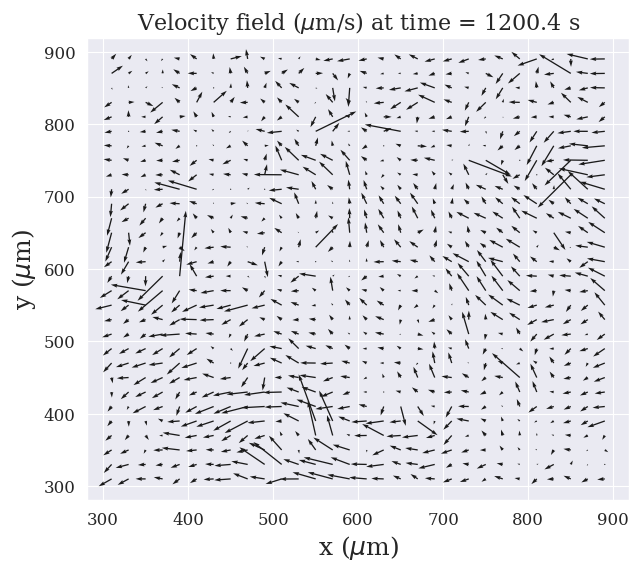

In [15]:
# For good measure, let us also plot the velocity flow field for frame 1
cst.plot_velocity_field(mode = 'field', frame_range = frame_range, \
    calculate_average = calculate_average, animate = animate, \
    frame_interval = frame_interval, use_interpolated_velocities=True, show = show)

MSD dataframe saved as csv file at:  C:\Users\Simon Andersen\Projects\Projects\CellSegmentationTracker\resources\epi2500_msd.csv 



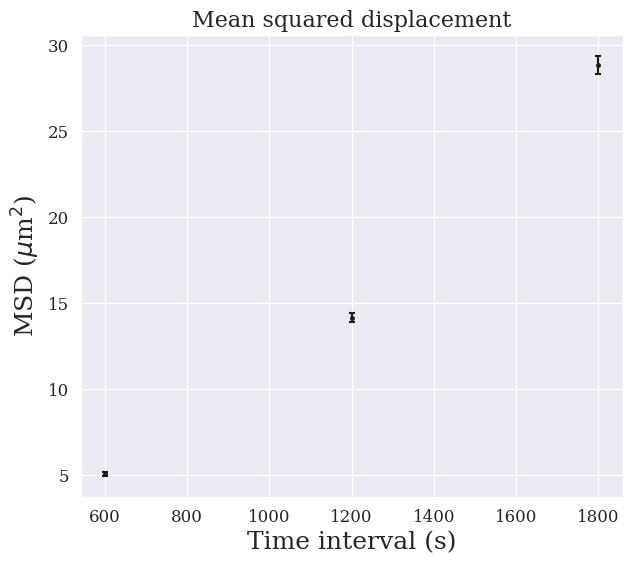

In [16]:
# Let us now calculate and plot the MSD (Mean square distance), 
#which is a measure of the average momvement of a cell over time.

# Set the maximum frame interval to calculate the MSD for, if None, 
# all frame intervals will be used
max_frame_interval = None

# Set the number of degrees of freedom to use in the calculation 
# of the MSD error. Default is 1
Ndof = 1

# Set whether to save the results to a csv file
save_csv = True

# Set the name of the csv file. 
# If None, the name will be named after the image

name = None
# Set whether to plot the MSD

plot = True
# Set whether to show the plot
show = True

msd_df = cst.calculate_msd(max_frame_interval = max_frame_interval, Ndof = Ndof, save_csv = save_csv, \
                  name = name, plot = plot, show = show)


CRMSD dataframe saved as csv file at:  C:\Users\Simon Andersen\Projects\Projects\CellSegmentationTracker\resources\epi2500_crmsd.csv 



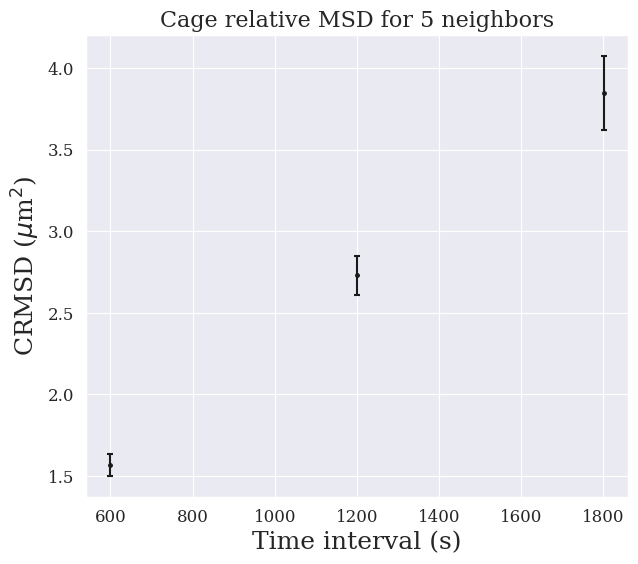

In [17]:
# Let us now calculate and plot the CRMSD (Cage relative mean square distance), 

# Set the number of nearest neighbours to use in the calculation. The default is 5
N_neighbors = 5

# All the remaining arguments are the same as for calculate_msd()
msd_df = cst.calculate_crmsd(N_neighbors = N_neighbors, max_frame_interval = max_frame_interval, Ndof = Ndof, save_csv = save_csv, \
                  name = name, plot = plot, show = show)

Coming soon:
- Density fluctuation function
- Velocity field interpolation of nan values
